In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from miriperformance_tools import load_data
np.__version__

'1.16.4'

**Imports**

* The statement _%matplotlib inline_ allows plotting in the notebook
* _numpy_ for numerical calculations and loading in the datasets
* _matplotlib_ for producing plots

** Contents of this Notebook**
1. Introduction
2. Loading and examining the datafiles
3. Sensitivity plot
4. Bright source limits plot
5. MRS Continuum and line sensitivity comparison plot
6. Imager and MRS extended source sensitivity plot


## 1. Introduction

In this notebook we produce plots of the MIRI sensitivities and saturation limits for JDox ([sensitivity](https://jwst-docs.stsci.edu/display/JTI/MIRI+Sensitivity) and [bright limits](https://jwst-docs.stsci.edu/display/JTI/MIRI+Bright+Source+Limits)) and the instrument pocket guide. The data read in were produced with the Pandeia ETC engine. The data files are in the data_files directory, within a subdirectory that indicates the ETC/Pandeia version used to produce the figures. 

We first define the data directory, indicating the ETC version used to produce the numbers.



In [2]:
data_dir = 'data_files/ETC1.5.1/'
out_dir = 'plots/ETC1.5.1/'

## 2. Load in the datafiles

We start by loading in the data files and take a look at what's in them.

The files contain saturation limits as well as limiting fluxes.  

In [3]:
im_file = data_dir + 'miri_imaging_sensitivity.npz'
im = np.load(im_file,encoding='bytes')
mrs_file = data_dir + 'miri_mrs_sensitivity.npz'
mrs = np.load(mrs_file,encoding='bytes',allow_pickle=True)
lrs_file = data_dir + 'miri_lrs_sensitivity.npz'
lrs = np.load(lrs_file,encoding='bytes', allow_pickle=True)


extim_file = data_dir + 'miri_imaging_sensitivity_extended.npz'
extim = np.load(extim_file,encoding='bytes')
extmrs_file = data_dir + 'miri_mrs_sensitivity_extended.npz'
extmrs = np.load(extmrs_file,encoding='bytes', allow_pickle=True)

Examine the contents of these file. These datafiles don't currently hold metadata; for background, the units are as follows:

* wavelengths in $\mu$m
* lim_fluxes and sat_limits in mJy
* line_limits in W/m$^2$
* extended source sensitivities in mJy/arcsec$^2$ and W/m$^2$/arcsec$^2$

In [4]:
imcols = im.keys()
lrscols = lrs.keys()
mrscols = mrs.keys()
#print(imcols, lrscols, mrscols)
#list(mrscols)
list(imcols)

['wavelengths', 'sns', 'lim_fluxes', 'sat_limits', 'configs']

In [5]:
print(im['lim_fluxes'])

[[0.00013127]
 [0.00024955]
 [0.00052084]
 [0.0012224 ]
 [0.00092605]
 [0.00145477]
 [0.00297154]
 [0.00514189]
 [0.01736011]]


In the MRS file, each key has 12 1-D arrays, each covering a sub-channel (4 channels * 3 sub-channels). We can look at how they are mapped with the 'configs' key:

In [6]:
print(mrs['configs'])

[{'aperture': 'ch1', 'disperser': 'short'}
 {'aperture': 'ch1', 'disperser': 'medium'}
 {'aperture': 'ch1', 'disperser': 'long'}
 {'aperture': 'ch2', 'disperser': 'short'}
 {'aperture': 'ch2', 'disperser': 'medium'}
 {'aperture': 'ch2', 'disperser': 'long'}
 {'aperture': 'ch3', 'disperser': 'short'}
 {'aperture': 'ch3', 'disperser': 'medium'}
 {'aperture': 'ch3', 'disperser': 'long'}
 {'aperture': 'ch4', 'disperser': 'short'}
 {'aperture': 'ch4', 'disperser': 'medium'}
 {'aperture': 'ch4', 'disperser': 'long'}]


Similarly for LRS:

In [7]:
list(lrs.keys())
print(lrs['configs'])

[{'aperture': 'imager', 'mode': 'lrsslitless'}
 {'aperture': 'lrsslit', 'mode': 'lrsslit'}]


Set up a few lists to better parse the MRS data files:

In [8]:
ishort = [0, 3, 6, 9]
imed = [i + 1 for i in ishort]
ilong = [i + 2 for i in ishort]
mrslabs = ['MRS short', '', '', '', 'MRS medium', '', '', '', 'MRS long', '', '', '']

In [9]:
# Parsing for each channel
ichan1 = [0, 1, 2]                        #S,M,L
ichan2 = [i + 3 for i in ichan1]
ichan3 = [i + 3 for i in ichan2]
ichan4 = [i + 3 for i in ichan3]

In [10]:
c1 = np.concatenate(mrs['sat_limits'][ichan1])
c2 = np.concatenate(mrs['sat_limits'][ichan2])
c3 = np.concatenate(mrs['sat_limits'][ichan3])
c4 = np.concatenate(mrs['sat_limits'][ichan4])
#print(np.amin(c1),np.amin(c2),np.amin(c3),np.amin(c4))
#lrsslitless = (lrs['sat_limits'][0]) * (2.775/0.159)
#print(lrsslitless)
#print(np.amin(lrs['sat_limits'][1]),np.amin(lrsslitless))
#print(im['sat_limits'])

In [11]:
#[i for i,x in enumerate(lrs['wavelengths'][0]) if x > 7.5 and x < 7.55]
[i for i,x in enumerate(lrs['wavelengths'][1]) if x > 7.5 and x < 7.55]

slitless_limit = lrs['sat_limits'][0][52] * (2.775/0.159)

print(slitless_limit)
print(lrs['sat_limits'][1][52])

1322.6171992825266
100.25840291089305


## 3. Sensitivity plot

In this section we'll produce a plot of the sensitivities of 4 MIRI modes: imager, LRS slit, LRS slitless and MRS, plotted together. This corresponds to Fig. 1 on [this JDox page](https://jwst-docs.stsci.edu/display/JTI/MIRI+Sensitivity). The values assume unresolved point sources, and indicate the minimum detectable flux in 10,000 seconds to reach SNR = 10. Spectroscopic values are given for continuum detection, in mJy. 

We create a few lists to identify the short, medium, long entries in the MRS file, so we can loop over it more easily, label the lines correctly and make the colours consistent. 


/Users/kmurray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


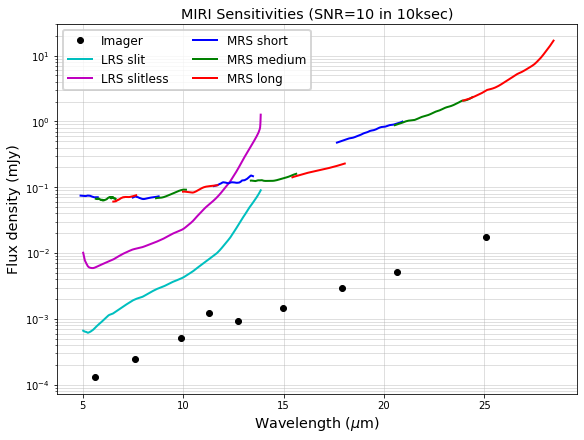

In [12]:

sens_fig = plt.figure(figsize=[8,6])
pim = plt.semilogy(im['wavelengths'], im['lim_fluxes'], 'ko', label = 'Imager')
pslit = plt.semilogy(lrs['wavelengths'][1], lrs['lim_fluxes'][1], color = 'c', label = 'LRS slit')
psless = plt.semilogy(lrs['wavelengths'][0], lrs['lim_fluxes'][0], color = 'm', label = 'LRS slitless')

for s in ishort:
    pshort = plt.semilogy(mrs['wavelengths'][s], mrs['lim_fluxes'][s], color = 'b', label=mrslabs[s])
for m in imed:
    pmed = plt.semilogy(mrs['wavelengths'][m], mrs['lim_fluxes'][m], color = 'g', label=mrslabs[m])
for l in ilong:
    plong = plt.semilogy(mrs['wavelengths'][l], mrs['lim_fluxes'][l], color = 'r', label=mrslabs[l])

plt.xlabel('Wavelength ($\mu$m)', fontsize='x-large')
plt.ylabel('Flux density (mJy)', fontsize='x-large')
plt.title('MIRI Sensitivities (SNR=10 in 10ksec)', fontsize='x-large')
plt.legend(loc='upper left', fontsize='large',ncol=2)
plt.savefig(out_dir + 'mirisensitivities_1.5.1etc.png', bbox_inches = 'tight')
sens_fig.show()

## 4. Bright source limits

These numbers describe when the MIRI detectors may saturate in its various observing modes. Assumptions:

* "Saturation" as defined in the ETC: when the electron count in a pixel reaches 70% of its full well capacity. this takes into account our ability correct for non-linearity. 
* NGroups = 5, which is the recommended minimum number for "regular" (i.e. non-TSO, not TA) science exposures.
* FAST readout mode and FULL array, i.e. 2.775 seconds per group.
* **NOTE**: for LRS slitless the values should therefore be scaled by the ratio of exposure times in FULL vs. SLITLESSPRISM subarray ($\times \frac{2.775}{0.159}$).

/Users/kmurray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


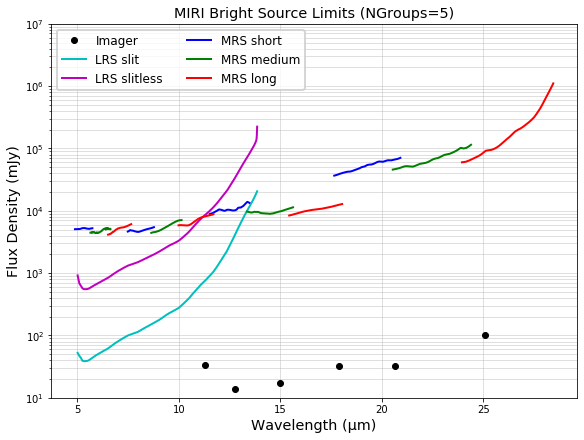

In [13]:
blim_fig = plt.figure(figsize=[8,6])
plt.semilogy(im['wavelengths'], im['sat_limits'],'ko', label = 'Imager')
plt.semilogy(lrs['wavelengths'][1], lrs['sat_limits'][1], color = 'c', label = 'LRS slit')
plt.semilogy(lrs['wavelengths'][0], lrs['sat_limits'][0] * (2.775/0.159), color = 'm', label = 'LRS slitless')

for s in ishort:
    plt.semilogy(mrs['wavelengths'][s], mrs['sat_limits'][s], color = 'b', label = mrslabs[s])
for m in imed:
    plt.semilogy(mrs['wavelengths'][m], mrs['sat_limits'][m], color = 'g', label = mrslabs[m])
for l in ilong:
    plt.semilogy(mrs['wavelengths'][l], mrs['sat_limits'][l], color = 'r', label = mrslabs[l])

plt.xlabel('Wavelength (µm)', fontsize='x-large')
plt.ylabel('Flux Density (mJy)', fontsize='x-large')
plt.ylim([10, 10e6])
plt.title('MIRI Bright Source Limits (NGroups=5)', fontsize='x-large')
plt.legend(loc='upper left', fontsize='large', ncol=2)

plt.savefig(out_dir + 'miribrightsourcelimits_1.5.1etc.png', bbox_inches = 'tight')
blim_fig.show()

## 5. Sensitivities, continuum + line

Thsi plots is the same as produced in section 2, but includes plots of limiting line fluxes for LRS and MRS (assuming an unresolved spectral line). 

/Users/kendrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


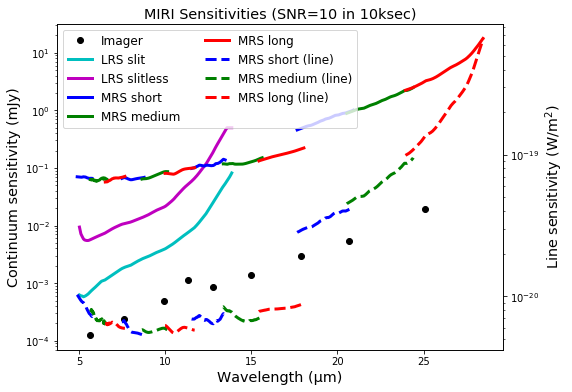

In [45]:
sensfig2, ax1 = plt.subplots(figsize=[8,6])
ax1.semilogy(im['wavelengths'], im['lim_fluxes'], 'ko', label = 'Imager')
ax1.semilogy(lrs['wavelengths'][1], lrs['lim_fluxes'][1], linewidth=3, color = 'c', label = 'LRS slit')
ax1.semilogy(lrs['wavelengths'][0], lrs['lim_fluxes'][0], linewidth=3, color = 'm', label = 'LRS slitless')


for s in ishort:
    ax1.semilogy(mrs['wavelengths'][s], mrs['lim_fluxes'][s], linewidth=3, color = 'b', label = mrslabs[s])
for m in imed:
    ax1.semilogy(mrs['wavelengths'][m], mrs['lim_fluxes'][m], linewidth=3, color = 'g', label = mrslabs[m])
for l in ilong:
    ax1.semilogy(mrs['wavelengths'][l], mrs['lim_fluxes'][l], linewidth=3, color = 'r', label = mrslabs[l])

ax1.set_xlabel('Wavelength (µm)', fontsize='x-large')
ax1.set_ylabel('Continuum sensitivity (mJy)', fontsize='x-large')
    

ax2 = ax1.twinx()
linelab_app = [' (line)', '', '', ''] * 3
linelabs = [m + l for m, l in zip(mrslabs, linelab_app)]

for s in ishort:
    ax2.semilogy(mrs['wavelengths'][s], mrs['line_limits'][s], linewidth=3, linestyle='--', color = 'b', label = linelabs[s])
for m in imed:
    ax2.semilogy(mrs['wavelengths'][m], mrs['line_limits'][m], linewidth=3, linestyle='--', color = 'g', label = linelabs[m])
for l in ilong:
    ax2.semilogy(mrs['wavelengths'][l], mrs['line_limits'][l], linewidth=3, linestyle='--', color = 'r', label = linelabs[l])
  
ax2.set_ylabel('Line sensitivity (W/m$^2$)', fontsize='x-large')
plt.title('MIRI Sensitivities (SNR=10 in 10ksec)', fontsize='x-large')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2, fontsize='large', ncol=2)

sensfig2.show()

### CLEANED UP DOWN TO HERE -- SK

In [50]:
ch1 = np.median(extmrs['lim_fluxes'][ichan1])
ch2 = np.median(extmrs['lim_fluxes'][ichan2])
ch3 = np.median(extmrs['lim_fluxes'][ichan3])
ch4 = np.median(extmrs['lim_fluxes'][ichan4])

#ch1=np.median(extmrs['lim_fluxes'][1])
#ch2=np.median(extmrs['lim_fluxes'][4])
#ch3=np.median(extmrs['lim_fluxes'][7])
#ch4=np.median(extmrs['lim_fluxes'][10])
print(ch1,ch2,ch3,ch4)
ch1line=np.median(extmrs['line_limits'][1])
ch2line=np.median(extmrs['line_limits'][4])
ch3line=np.median(extmrs['line_limits'][7])
ch4line=np.median(extmrs['line_limits'][10])
print(ch1line,ch2line,ch3line,ch4line)
ch1pt=np.median(mrsup['lim_fluxes'][1])
ch2pt=np.median(mrsup['lim_fluxes'][4])
ch3pt=np.median(mrsup['lim_fluxes'][7])
ch4pt=np.median(mrsup['lim_fluxes'][10])
print(ch1pt,ch2pt,ch3pt,ch4pt)
ch1ptline=np.median(mrsup['line_limits'][1])
ch2ptline=np.median(mrsup['line_limits'][4])
ch3ptline=np.median(mrsup['line_limits'][7])
ch4ptline=np.median(mrsup['line_limits'][10])
print(ch1ptline,ch2ptline,ch3ptline,ch4ptline)

ValueError: operands could not be broadcast together with shapes (913,) (927,) 

In [ ]:
lrsslit=np.median(lrsup['lim_fluxes'][1])
lrsslitless=np.median(lrsup['lim_fluxes'][0])
print(lrsslit,lrsslitless)
lrsslitline=np.median(lrsup['line_limits'][1])
lrsslitlessline=np.median(lrsup['line_limits'][0])
print(lrsslitline,lrsslitlessline)

In [ ]:
print(imaup['lim_fluxes'])
print(extim['lim_fluxes'])

In [ ]:
contfig, cax1 = plt.subplots()
cax1.semilogy(imaup['wavelengths'], imaup['lim_fluxes'], 'bo', color = 'black', label = 'Imager for Point')
cax1.semilogy(lrsup['wavelengths'][1], lrsup['lim_fluxes'][1], linewidth=3, color = 'c', label = 'LRS Slit for point')
cax1.semilogy(lrsup['wavelengths'][0], lrsup['lim_fluxes'][0], linewidth=3, color = 'm', label = 'LRS Slitless for point')
cax1.semilogy(mrsup['wavelengths'][0], mrsup['lim_fluxes'][0], linewidth=3, color = 'b', label = 'MRS Short for point')
cax1.semilogy(mrsup['wavelengths'][1], mrsup['lim_fluxes'][1], linewidth=3, color = 'g', label = 'MRS Medium for point')
cax1.semilogy(mrsup['wavelengths'][2], mrsup['lim_fluxes'][2], linewidth=3, color = 'r', label = 'MRS Long point')
cax1.semilogy(mrsup['wavelengths'][3], mrsup['lim_fluxes'][3], linewidth=3, color = 'b')
cax1.semilogy(mrsup['wavelengths'][4], mrsup['lim_fluxes'][4], linewidth=3, color = 'g')
cax1.semilogy(mrsup['wavelengths'][5], mrsup['lim_fluxes'][5], linewidth=3, color = 'r')
cax1.semilogy(mrsup['wavelengths'][6], mrsup['lim_fluxes'][6], linewidth=3, color = 'b')
cax1.semilogy(mrsup['wavelengths'][7], mrsup['lim_fluxes'][7], linewidth=3, color = 'g')
cax1.semilogy(mrsup['wavelengths'][8], mrsup['lim_fluxes'][8], linewidth=3, color = 'r')
cax1.semilogy(mrsup['wavelengths'][9], mrsup['lim_fluxes'][9], linewidth=3, color = 'b')
cax1.semilogy(mrsup['wavelengths'][10], mrsup['lim_fluxes'][10], linewidth=3, color = 'g')
cax1.semilogy(mrsup['wavelengths'][11], mrsup['lim_fluxes'][11], linewidth=3, color = 'r')
cax1.set_xlabel('Wavelength (µm)', fontsize='20')
cax1.set_ylabel('Flux density for point sources (mJy)', fontsize='20')
cax1.tick_params(axis='both', labelsize='x-large')
cax2 = cax1.twinx()
cax2.semilogy(extim['wavelengths'], extim['lim_fluxes'], 'bo', color = 'black', label = 'Imager for extended', marker='^')
cax2.semilogy(extmrs['wavelengths'][0], extmrs['lim_fluxes'][0], linewidth=3, color = 'b', label = 'MRS Short for extended', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][1], extmrs['lim_fluxes'][1], linewidth=3, color = 'g', label = 'MRS Medium for extended', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][2], extmrs['lim_fluxes'][2], linewidth=3, color = 'r', label = 'MRS Long for extended', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][3], extmrs['lim_fluxes'][3], linewidth=3, color = 'b', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][4], extmrs['lim_fluxes'][4], linewidth=3, color = 'g', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][5], extmrs['lim_fluxes'][5], linewidth=3, color = 'r', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][6], extmrs['lim_fluxes'][6], linewidth=3, color = 'b', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][7], extmrs['lim_fluxes'][7], linewidth=3, color = 'g', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][8], extmrs['lim_fluxes'][8], linewidth=3, color = 'r', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][9], extmrs['lim_fluxes'][9], linewidth=3, color = 'b', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][10], extmrs['lim_fluxes'][10], linewidth=3, color = 'g', linestyle = 'dashed')
cax2.semilogy(extmrs['wavelengths'][11], extmrs['lim_fluxes'][11], linewidth=3, color = 'r', linestyle = 'dashed')
cax2.set_xlabel('Wavelength (µm)', fontsize='20')
cax2.set_ylabel('Flux density for extended sources (mJy/$arcsec^2$)', fontsize='20')
cax2.tick_params(axis='both', labelsize='x-large')
ch1, cl1 = cax1.get_legend_handles_labels()
ch2, cl2 = cax2.get_legend_handles_labels()
cax1.legend(ch1+ch2, cl1+cl2, loc=2, fontsize='x-large')
plt.title('MIRI Continuum Sensitivities (SNR=10 in 10ksec)', fontsize='22')
plt.savefig('mirisensitivities_continuum.png', bbox_inches = 'tight')
plt.show()

In [ ]:
linefig, lax1 = plt.subplots()
lax1.semilogy(lrsup['wavelengths'][1], lrsup['line_limits'][1], linewidth=3, color = 'c', label = 'LRS Slit for point')
lax1.semilogy(lrsup['wavelengths'][0], lrsup['line_limits'][0], linewidth=3, color = 'm', label = 'LRS Slitless for point')
lax1.semilogy(mrsup['wavelengths'][0], mrsup['line_limits'][0], linewidth=3, color = 'b', label = 'MRS Short for point')
lax1.semilogy(mrsup['wavelengths'][1], mrsup['line_limits'][1], linewidth=3, color = 'g', label = 'MRS Medium for point')
lax1.semilogy(mrsup['wavelengths'][2], mrsup['line_limits'][2], linewidth=3, color = 'r', label = 'MRS Long Point for point')
lax1.semilogy(mrsup['wavelengths'][3], mrsup['line_limits'][3], linewidth=3, color = 'b')
lax1.semilogy(mrsup['wavelengths'][4], mrsup['line_limits'][4], linewidth=3, color = 'g')
lax1.semilogy(mrsup['wavelengths'][5], mrsup['line_limits'][5], linewidth=3, color = 'r')
lax1.semilogy(mrsup['wavelengths'][6], mrsup['line_limits'][6], linewidth=3, color = 'b')
lax1.semilogy(mrsup['wavelengths'][7], mrsup['line_limits'][7], linewidth=3, color = 'g')
lax1.semilogy(mrsup['wavelengths'][8], mrsup['line_limits'][8], linewidth=3, color = 'r')
lax1.semilogy(mrsup['wavelengths'][9], mrsup['line_limits'][9], linewidth=3, color = 'b')
lax1.semilogy(mrsup['wavelengths'][10], mrsup['line_limits'][10], linewidth=3, color = 'g')
lax1.semilogy(mrsup['wavelengths'][11], mrsup['line_limits'][11], linewidth=3, color = 'r')
lax1.set_ylabel('Flux density for Extended Sources (W/$m^2$)', fontsize='20')
lax1.tick_params(axis='both', labelsize='x-large')
lax2 = lax1.twinx()
lax2.semilogy(extmrs['wavelengths'][0], extmrs['line_limits'][0], color = 'b', linewidth=3, linestyle = 'dashed', label = 'MRS Short for extended')
lax2.semilogy(extmrs['wavelengths'][1], extmrs['line_limits'][1], color = 'g', linewidth=3, linestyle = 'dashed', label = 'MRS Medium for extended')
lax2.semilogy(extmrs['wavelengths'][2], extmrs['line_limits'][2], color = 'r', linewidth=3, linestyle = 'dashed', label = 'MRS Long for extended')
lax2.semilogy(extmrs['wavelengths'][3], extmrs['line_limits'][3], color = 'b', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][4], extmrs['line_limits'][4], color = 'g', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][5], extmrs['line_limits'][5], color = 'r', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][6], extmrs['line_limits'][6], color = 'b', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][7], extmrs['line_limits'][7], color = 'g', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][8], extmrs['line_limits'][8], color = 'r', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][9], extmrs['line_limits'][9], color = 'b', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][10], extmrs['line_limits'][10], color = 'g', linewidth=3, linestyle = 'dashed')
lax2.semilogy(extmrs['wavelengths'][11], extmrs['line_limits'][11], color = 'r', linewidth=3, linestyle = 'dashed')
#ax2.xlabel('Wavelength (µm)')
lax2.set_ylabel('Flux density for Point Sources (W/$m^2$/$arcsec^2$)', fontsize='20')
lax2.tick_params(axis='both', labelsize='x-large')
lh1, ll1 = lax1.get_legend_handles_labels()
lh2, ll2 = lax2.get_legend_handles_labels()
lax1.legend(lh1+lh2, ll1+ll2, loc=2, fontsize='x-large')
plt.title('MIRI Line Sensitivities (SNR=10 in 10ksec)', fontsize='22')
plt.savefig('mirisensitivities_justline.png', bbox_inches = 'tight')
plt.show()

In [ ]:
sensfig2, ax1 = plt.subplots(figsize=[10,8])
ax1.semilogy(im['wavelengths'], im['lim_fluxes'], 'ko', label = 'Imager')
ax1.semilogy(lrs['wavelengths'][1], lrs['lim_fluxes'][1], linewidth=3, color = 'c', label = 'LRS slit')
ax1.semilogy(lrs['wavelengths'][0], lrs['lim_fluxes'][0], linewidth=3, color = 'm', label = 'LRS slitless')


for s in ishort:
    ax1.semilogy(mrs['wavelengths'][s], mrs['lim_fluxes'][s], linewidth=3, color = 'b', label = mrslabs[s])
for m in imed:
    ax1.semilogy(mrs['wavelengths'][m], mrs['lim_fluxes'][m], linewidth=3, color = 'g', label = mrslabs[m])
for l in ilong:
    ax1.semilogy(mrs['wavelengths'][l], mrs['lim_fluxes'][l], linewidth=3, color = 'r', label = mrslabs[l])

ax1.set_xlabel('Wavelength (µm)')
ax1.set_ylabel('Sensitivity (mJy)')

plt.title('MIRI Continuum Sensitivities (SNR=10 in 10ksec)')
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc=2, fontsize='large', ncol=2)
ax1.grid(b=bool)
sensfig2.savefig(out_dir + 'mirisensitivities_continuum.png', bbox_inches = 'tight')
sensfig2.savefig(out_dir + 'mirisensitivities_continuum.pdf', bbox_inches = 'tight')

#sensfig2.show()

In [ ]:
#newList = [x / myInt for x in myList]
#print(10**-20)

slit_1020limits = lrs['line_limits'][1] / (10**-20)
slitless_1020limits = lrs['line_limits'][0] / (10**-20)
mrsSH_1020limits = [x / (10**-20) for x in mrs['line_limits'][s]] 
mrsMED_1020limits = [x / (10**-20) for x in mrs['line_limits'][m]] 
mrsLG_1020limits = [x / (10**-20) for x in mrs['line_limits'][l]] 

print(len(mrsSH_1020limits))
print(len(mrs['line_limits'][s]))
print(len(mrs['wavelengths'][s]))
mrs_shwl = [x for x in mrs['wavelengths'][s]]
mrs_medwl = [x for x in mrs['wavelengths'][m]]
mrs_lgwl = [x for x in mrs['wavelengths'][l]]
print(len(mrs_shwl))

In [ ]:
sensfig3, ax2 = plt.subplots(figsize=[10,8])
linelab_app = [' (line)', '', '', ''] * 3
linelabs = [m + l for m, l in zip(mrslabs, linelab_app)]

ax2.semilogy(lrs['wavelengths'][1], slit_1020limits, linewidth=3, color = 'c', label = 'LRS slit')
ax2.semilogy(lrs['wavelengths'][0], slitless_1020limits, linewidth=3, color = 'm', label = 'LRS slitless')

for s in ishort:
    ax2.semilogy(mrs['wavelengths'][s], mrs['line_limits'][s] / (10**-20), linewidth=3, color = 'b', label = linelabs[s])
for m in imed:
    ax2.semilogy(mrs['wavelengths'][m], mrs['line_limits'][m] / (10**-20), linewidth=3, color = 'g', label = linelabs[m])
for l in ilong:
    ax2.semilogy(mrs['wavelengths'][l], mrs['line_limits'][l] / (10**-20), linewidth=3, color = 'r', label = linelabs[l])
  
ax2.set_xlabel('Wavelength (µm)')
ax2.set_ylabel('Sensitivity $(10^{-20} W/m^2)$')

plt.title('MRS Line Sensitivities (SNR=10 in 10ksec)')
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, loc=2, fontsize='large', ncol=2)
ax2.grid(b=bool)

sensfig3.savefig(out_dir + 'mirisensitivities_line.png', bbox_inches = 'tight')
sensfig3.savefig(out_dir + 'mirisensitivities_line.pdf', bbox_inches = 'tight')

sensfig3.show()

In [ ]:
# Parsing for each channel
ichan1 = [0, 1, 2]                        #S,M,L
ichan2 = [i + 3 for i in ichan1]
ichan3 = [i + 3 for i in ichan2]

In [ ]:
# Combining S M L arrays to a single array
c1 = np.concatenate(mrs[‘wavelengths’][ichan1])